In [1]:
# Import Libraries, Set Plotting Options

import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import fiona
import seaborn as sns
from rasterio.warp import reproject, Resampling
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from scipy.stats import *
%matplotlib inline
sns.set(color_codes=True)

In [2]:
dem_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/bare_earth/clpx_june5_2017_DEM.tif')
dem_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16384,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 397068.0,
       0.0, -1.0, 7624870.0),
 'width': 20480}

In [4]:
snow_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/clpx_096_2016.tif')
snow_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 19661,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 396460.8,
       0.0, -1.0, 7624716.0),
 'width': 19661}

In [19]:
# I Used this function to crop the 2016 snow surface to the 2017 DEM AND crop the 2017 DEM to the 2016 snow surface.
# The resulting files (DEM crop and snow surface crop) are aligned with one another and the same size so I can difference
# the two files accurately.

def crop( large_rst, small_rst, output_path=None, compress=True, *args, **kwargs ):
	'''
	crop a larger raster by a smaller overlapping one.
	this function assumes the 2 rasters are in the same CRS
	arguments:
	----------
	large_rst = rasterio.raster object of the larger raster to be cropped
	small_rst = rasterio.raster object of the smaller raster used to crop the larger
	output_path = [optional] string path to directory to output the new GTiff created. 
		if None, it will be the directory of the large_rst.
	compress = boolean. Default = True.  If True lzw-compress. if False do not.
	returns:
	--------
	path to the newly generated cropped raster.  With the side-effect of outputting the 
	raster to disk.
	notes:
	------
	potential gotcha here is that it will only work on a single banded raster.
	'''
	import rasterio, os

	window = large_rst.window( *small_rst.bounds )
	crop_affine = large_rst.window_transform( window )
	window_arr = large_rst.read( 1, window=window )
	# make a new meta object to pass to the cropped raster
	height, width = window_arr.shape
	meta = small_rst.meta
	meta.update( affine=crop_affine,
				height=height,
				width=width,
				nodata=large_rst.nodata,
				crs=large_rst.crs,
				count=1,
				dtype=large_rst.dtypes[0] )

	output_name = os.path.basename( large_rst.name ).replace( '.tif', '_crop.tif' )

	if output_path:
		output_filename = os.path.join( output_path, output_name )
	else:
		output_path = os.path.dirname( large_rst.name )
		output_filename = os.path.join( output_path, output_name )

	with rasterio.open( output_filename, 'w', **meta ) as out:
		out.write( window_arr, 1 )
	return output_filename



/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: The 'affine' kwarg in rasterio.open() is deprecated at 1.0 and only remains to ease the transition.  Please switch to the 'transform' kwarg.  See https://github.com/mapbox/rasterio/issues/86 for details.
/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/rasterio/__init__.py:202: UserWarning: Found both 'affine' and 'transform' in rasterio.open() - choosing 'transform'
  "Found both 'affine' and 'transform' in rasterio.open() - "


'/home/cparr/surfaces/level_1_surfaces/clpx/clpx_096_2016_crop.tif'

In [ ]:
large_rst = snow_src
small_rst = dem_src
crop(large_rst, small_rst)
large_rst = dem_src
small_rst = snow_src
crop(large_rst, small_rst)

In [3]:
demcrop_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/bare_earth/clpx_june5_2017_DEM_crop.tif')
demcrop_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16230,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 396460.8,
       0.0, -1.0, 7624716.0),
 'width': 19054}

In [6]:
snowcrop_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/clpx_096_2016_crop.tif')
snowcrop_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16230,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 397068.0,
       0.0, -1.0, 7624870.0),
 'width': 19054}

In [9]:
depth17_src = rasterio.open('/home/cparr/surfaces/depth_ddems/clpx/clpx_2017_dDEM_036m_offset.tif')
depth17_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16384,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 397068.0,
       0.0, -1.0, 7624870.0),
 'width': 20480}

In [36]:
depth = snowcrop_src.read(1) - demcrop_src.read(1)

/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


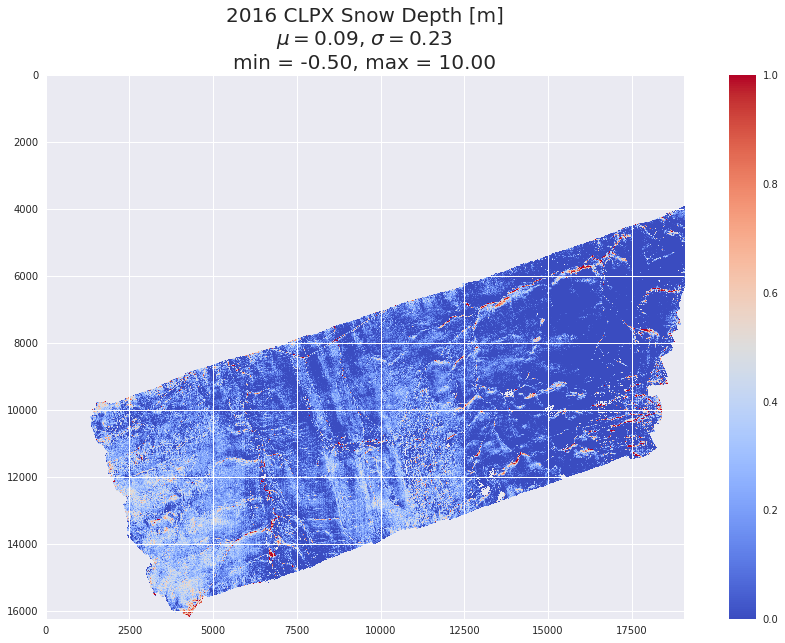

In [37]:
depth[depth < -0.5] = np.nan
depth[depth > 10] = np.nan

mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)
im = ax.imshow(depth,vmin=0, vmax=1, cmap ='coolwarm')
ax.set_title("2016 CLPX Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

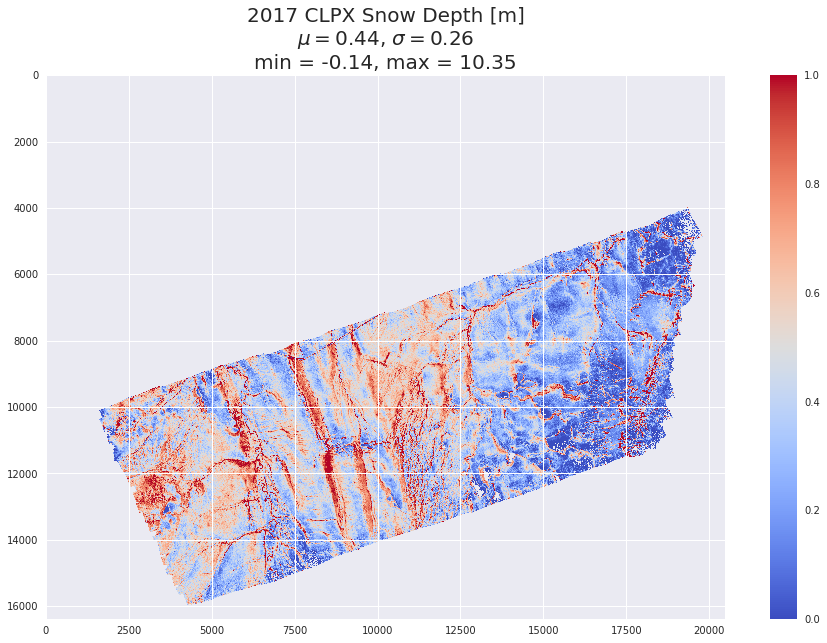

In [12]:
mu = np.nanmean(depth17_src.read(1))
sigma = np.nanstd(depth17_src.read(1))
dmin = np.nanmin(depth17_src.read(1))
dmax = np.nanmax(depth17_src.read(1))

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)
im = ax.imshow(depth17_src.read(1), vmin=0, vmax=1, cmap ='coolwarm')
ax.set_title("2017 CLPX Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

In [18]:
out_meta = snowcrop_src.meta.copy()
with rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_096_2016_dDEM_no_offset.tif",
                   "w", **out_meta) as dest:
    dest.write(depth,1)

In [19]:
ddem_src = rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_096_2016_dDEM_no_offset.tif")

In [26]:
# This code block reads in the MagnaProbe shapefile and then compares the depth of the dDEM and the probe 
# measuremnt at each probe location.

with fiona.open("/home/cparr/probes/clpx/imnavait_042016_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
errors = []
sfm = []
probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    errors.append(probe_sfm_diff)
    sfm.append(sfm_depth)
    probe.append(probe_depth)
    
sfm = np.array(sfm)
probe = np.array(probe)
errors = np.array(errors)

For each MagnaProbe measurement I subtracted the dDEM measurment at the same location. Let's take a look at how the two measurement types compare.

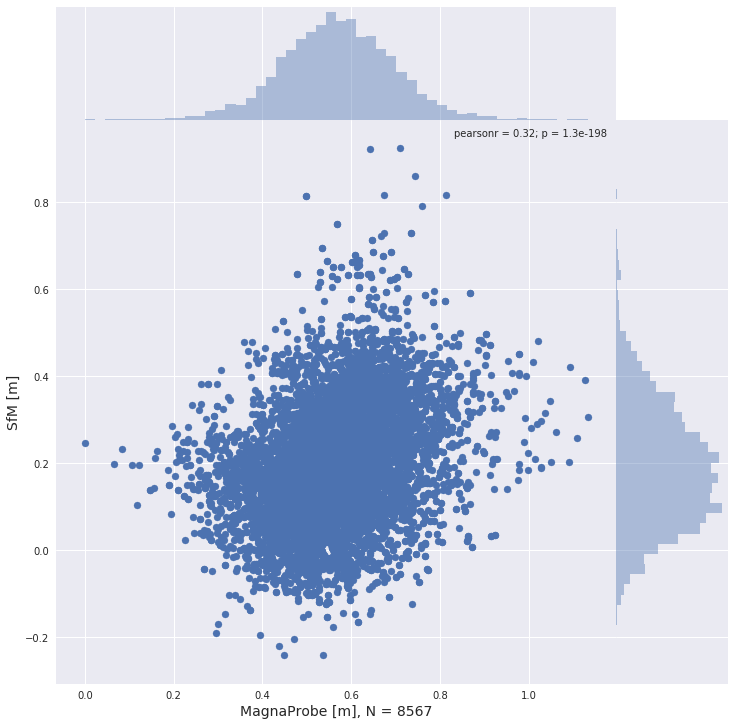

In [27]:
ax = (sns.jointplot(x=probe, y=sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(probe.size), "SfM [m]", fontsize=14))

The two samples correlate pretty well and the distributions look similar. Let's check the errors.

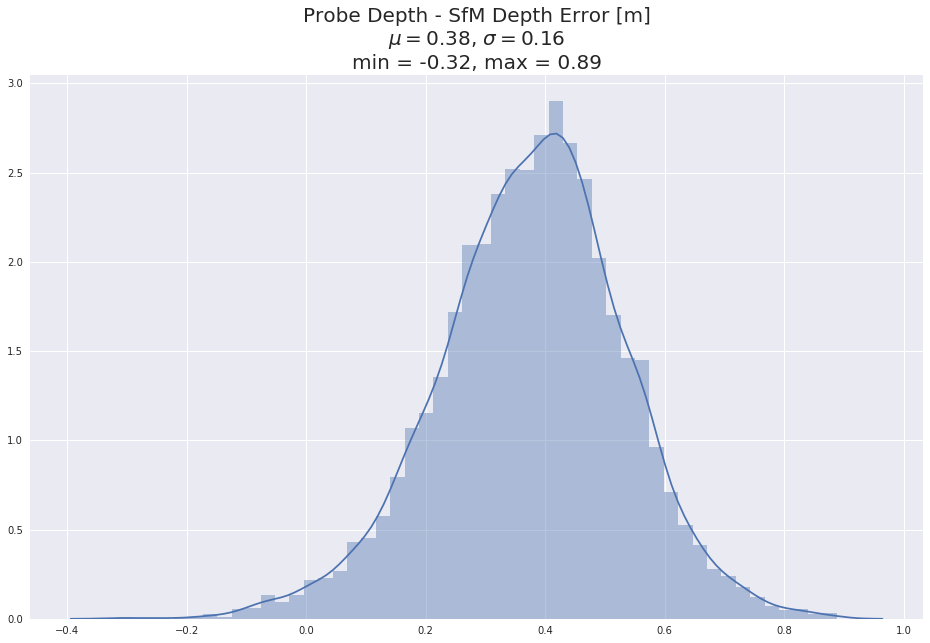

In [28]:
mu = np.nanmean(errors)
sigma = np.nanstd(errors)
dmin = np.nanmin(errors)
dmax = np.nanmax(errors)

plt.figure(figsize=(16,10))
ax = sns.distplot(errors, hist=True)
ax.set_title('Probe Depth - SfM Depth Error [m]' +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax), fontsize=20)

In [29]:
with fiona.open("/home/cparr/probes/clpx/clpx_042016_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
errors = []
sfm = []
probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    errors.append(probe_sfm_diff)
    sfm.append(sfm_depth)
    probe.append(probe_depth)
    
sfm = np.array(sfm)
probe = np.array(probe)
errors = np.array(errors)

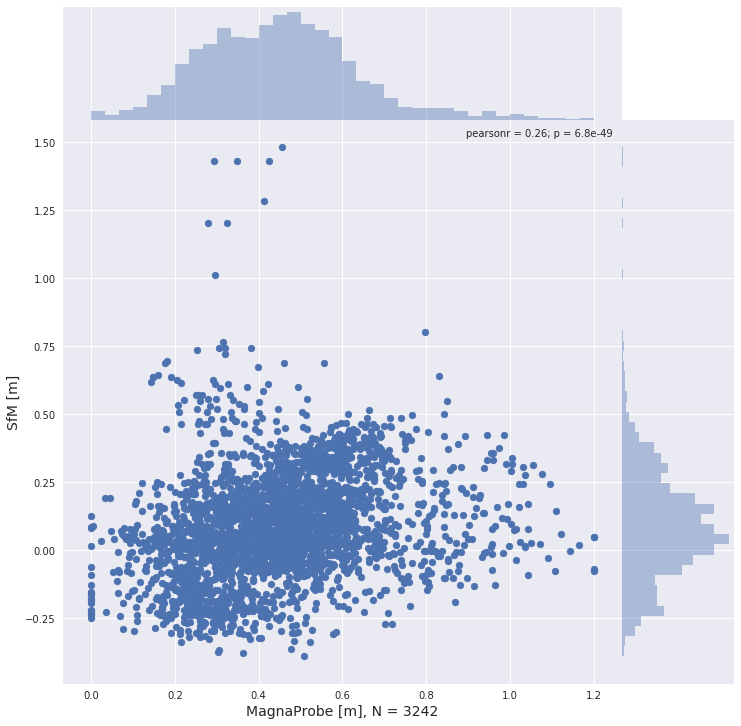

In [30]:
ax = (sns.jointplot(x=probe, y=sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(probe.size), "SfM [m]", fontsize=14))

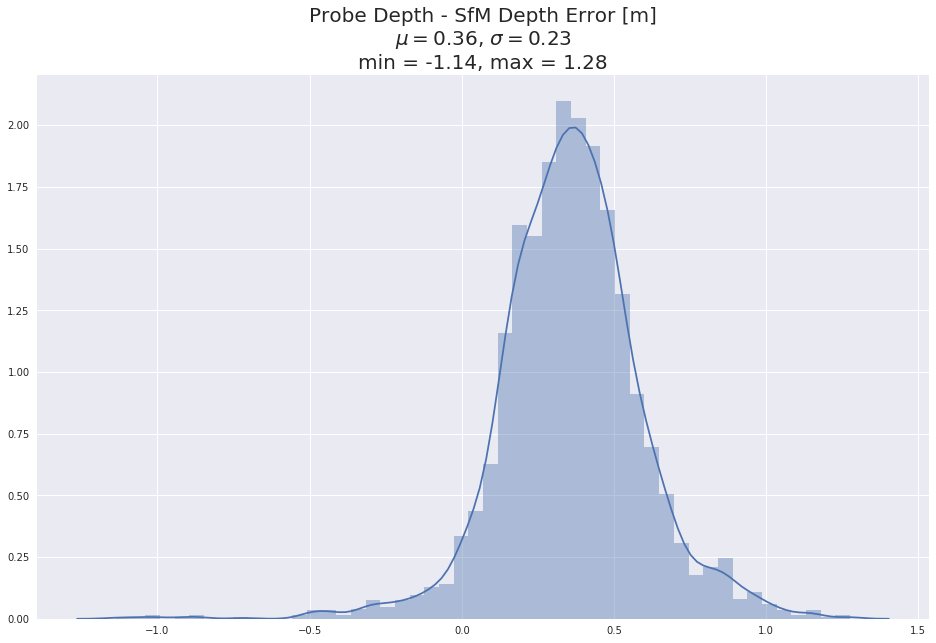

In [32]:
errors = errors[~np.isnan(errors)]

mu = np.nanmean(errors)
sigma = np.nanstd(errors)
dmin = np.nanmin(errors)
dmax = np.nanmax(errors)

plt.figure(figsize=(16,10))
ax = sns.distplot(errors, hist=True)
ax.set_title('Probe Depth - SfM Depth Error [m]' +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax), fontsize=20)

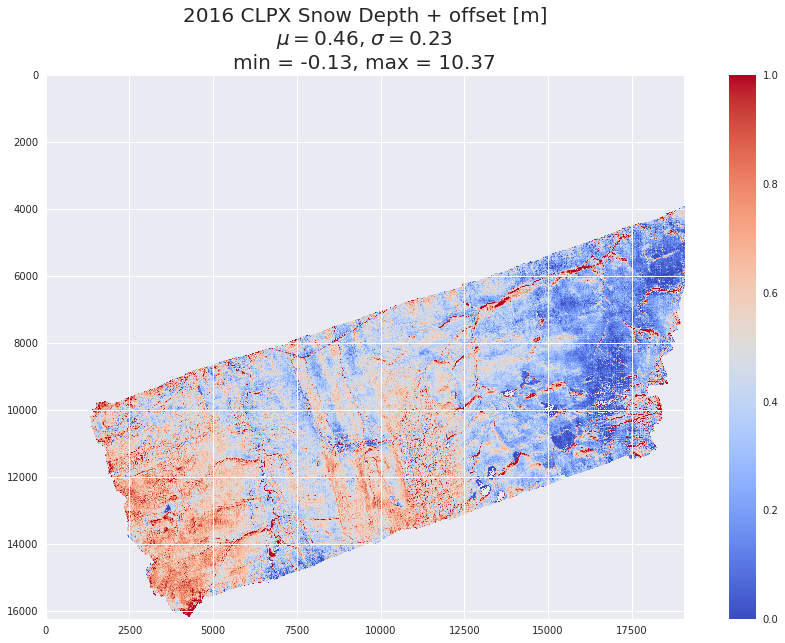

In [38]:
depth = depth + 0.37
mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

im = ax.imshow(depth,vmin=0, vmax=1, cmap ='coolwarm')

ax.set_title("2016 CLPX Snow Depth + offset [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

In [39]:
with rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_096_2016_dDEM_037m_offset.tif",
                   "w", **out_meta) as dest:
    dest.write(depth,1)